# Rational Verification

This notebook contains the code for Janick Rüegger's bachelor thesis "Hashed Timelock Contracts - An Incentive Analysis". 

The thesis can be found in the same repository in `pdf` format.

## Imports

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc

## Currency

In [2]:
class Currency:
    def __init__(self, r_0, q, mu):
        self.r_0 = r_0
        self.q = q
        self.s_0 = r_0 * q
        self.mu = mu

## Strategic Game

#### Decision Tree

In [3]:
class Tree:
    def __init__(self, r):
        self.r = r

#### Node

In [4]:
class Node:
    def __init__(self, h, l, r, n, u_i, u_j):
        self.h = h
        self.l = l
        self.r = r
        self.n = n
        self.u_i = u_i
        self.u_j = u_j

#### Build Tree

In [5]:
def build_tree(payoffs_i, payoffs_j):
    z4 = Node(3, None, None, "i", payoffs_i[3], payoffs_j[3])
    z3 = Node(2, None, None, "i", payoffs_i[2], payoffs_j[2])
    h3 = Node(2, z3, z4, "j", None, None)
    z2 = Node(1, None, None, "j", payoffs_i[1], payoffs_j[1])
    h2 = Node(1, z2, h3, "i", None, None)
    z1 = Node(0, None, None, "i", payoffs_i[0], payoffs_j[0])
    h1 = Node(0, z1, h2, None, None, None)
    tree = Tree(h1)
    
    return tree

#### Backwards Induction

In [6]:
def backwards_induction(tree):
    leaves = []
    node = tree.r
    
    # find all leaves
    while True:
        if node.l == None and node.r == None:
            leaves.append(node)
        else:    
            leaves.append(node.l)
        if node.r is None:
            break
        node = node.r
        
    # calc nash equilibrium
    nash_eq = None
    
    for leaf in reversed(leaves):
        if nash_eq is None:
            nash_eq = leaf
        else:
            if leaf.n == "i":
                if leaf.u_i > nash_eq.u_i:
                    nash_eq = leaf
            else:
                    if leaf.u_j > nash_eq.u_j:
                        nash_eq = leaf

    return nash_eq.u_i, nash_eq.u_j

##### Example: Build a decision tree and calculate the Nash equilibrium

In [32]:
# example
tree = build_tree([0,-1,-1,20],[0,0,-1,0])
result = backwards_induction(tree)

print("Nash Equilibrium = " + str(result[0]) + ", " + str(result[1]))

Nash Equilibrium = 20, 0


## Utility Function

#### Step Function $\chi_0(t)$

In [8]:
def chi_0(t_x):
    if t_x >= 4:
        raise Exception('t_x should not exceed 4 (max value of t_final). The value of t_x was: {}'.format(t))
    elif t_x < 0:
        raise Exception('t_x should not be negative. The value of t_x was: {}'.format(t))
    elif t_x == 3:
        return 1, 1
    else: 
        return 0, 0

#### Step Function $\chi_1(t)$

In [9]:
def chi_1(t_x):
    if t_x >= 4:
        raise Exception('t_x should not exceed 4 (max value of t_final). The value of t_x was: {}'.format(t))
    elif t_x < 0:
        raise Exception('t_x should not be negative. The value of t_x was: {}'.format(t))
    elif t_x == 3:
        return 2, 2
    elif t_x == 2:
        return 1, 1
    elif t_x == 1:
        return 1, 0
    elif t_x == 0:
        return 0, 0

#### Payoffs

In [31]:
def payoffs(cy_i, cy_j, R_ix, t_x):
    # gamma and eta fixed
    gamma = 0.02
    eta = 0
    
    R_jx = 1 / R_ix  
    t_n = 100 - t_x
    
    payoffs_i = []
    payoffs_j = []
    
    # estimate end returns
    est_i = estimate_return(R_ix, cy_i, t_n)
    est_j = estimate_return(R_jx, cy_j, t_n)
    
    # calculate payoffs for all four choice nodes
    for t in range(4):
        chi_0_i, chi_0_j = chi_0(t)
        chi_1_i, chi_1_j = chi_1(t)

        u_i = chi_0_i * ((est_i-cy_i.s_0) + (cy_i.s_0 * gamma)) - (chi_1_i * eta)
        u_j = chi_0_j * ((est_j-cy_j.s_0) + (cy_j.s_0 * gamma)) - (chi_1_j * eta)
        
        payoffs_i.append(u_i)
        payoffs_j.append(u_j)
        
    return payoffs_i, payoffs_j

## Geometric Brownian Motions

#### Geometric Brownian Motion

In [11]:
def geometric_brownian_motion(S_0, mu, sigma):
    # create timeline t_i
    t_final = 100
    t_i = np.linspace(0, t_final, t_final+1)
    
    # create Wiener-process
    W_t = np.cumsum(np.random.standard_normal(size=t_final+1))*np.sqrt(1)
    
    # create exchange-rate
    S_i = np.array([S_0])
    
    for t in range(t_final+1):
        if t != 0:
            S_x = S_0*np.exp(((mu-(sigma**2/2))*t)+sigma*W_t[t])
            S_i = np.append(S_i, S_x)

    return t_i, S_i;

#### Estimate Return $E(S_t)$

In [12]:
def estimate_return(R_x, cy_x, t_n):
    exp = cy_x.mu*(t_n)
    est = cy_x.s_0* R_x * math.exp(exp)
    return est

##### Example: Draw a geometric Brownian motion

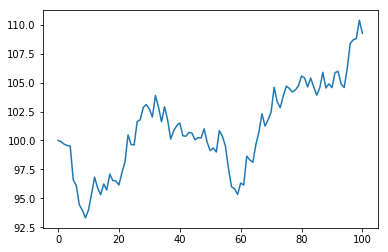

In [15]:
# draw a gbm with S_0 = 100, mu = 0.0 and delta = 0.01 (t = 100 implied)
t_i, R_i = geometric_brownian_motion(100, 0.0, 0.01)
plt.plot(t_i, R_i)

## Rational Verification

In [43]:
class TestRange:
    def __init__(self, gbm_per_try, cy_i, cy_j, r0, mu, delta):
        self.gbm_per_try = gbm_per_try
        
        self.succeded = 0
        self.failed = 0
        self.end_values = []
        
        self.cy_i = cy_i
        self.cy_j = cy_j
        self.r0 = r0
        self.mu = mu
        self.delta = delta
        
    # used for testing delta
    def test_delta(self):
        for i in range(self.gbm_per_try): 
            # create a brownian motion
            t_i, R_i = geometric_brownian_motion(self.r0, self.mu, self.delta)
            plt.plot(t_i, R_i)
            self.end_values.append(R_i[-1])

            # decision: initiate
            t_x = 10
            R_ix = R_i[t_x+1]

            if self.evaluate(t_x, R_ix, cy_i, cy_j) == False:
                self.failed += 1   
                continue

            # decision: adapt
            t_x = 80
            R_ix = R_i[t_x+1]

            if self.evaluate(t_x, R_ix, cy_i, cy_j) == False:
                self.failed += 1 
                continue

            # decision: redeem
            t_x = 90
            R_ix = R_i[t_x+1]

            if self.evaluate(t_x, R_ix, cy_i, cy_j) == False:
                self.failed += 1 
            else:
                self.succeded += 1
                
        plt.xlabel(r'Time $(t)$', fontsize=12)
        plt.ylabel(r'Exchange-Rate', fontsize=12)
        plt.title(r'GBM with: $n = 2000, t = 100, \mu = 0.0, \delta = $' + str(delta),fontsize=16)
        plt.show()
        
        plt.hist(self.end_values, 40, orientation="horizontal")
        plt.xlabel(r'Number of Occurance', fontsize=12)
        plt.ylabel(r'Exchange-Rate at $t_{final}$', fontsize=12)
        plt.title(r'GBM with: $n = 100, t = 100, \mu = 0.0, \delta = 0.001$',fontsize=16)
        plt.show()
        
    # used for testing mu
    def test_mu(self):
        t_i, R_i = geometric_brownian_motion(self.r0, self.mu, self.delta)
        plt.plot(t_i, R_i)
        
        self.end_values.append(R_i[-1])

        # decision: initiate
        t_x = 10
        R_ix = R_i[t_x+1]

        if self.evaluate(t_x, R_ix, cy_i, cy_j) == False:
            return 0.0   

        # decision: adapt
        t_x = 80
        R_ix = R_i[t_x+1]


        if self.evaluate(t_x, R_ix, cy_i, cy_j) == False:
            return 0.0

        # decision: redeem
        t_x = 90
        R_ix = R_i[t_x+1]

        if self.evaluate(t_x, R_ix, cy_i, cy_j) == False:
            return 0.0 
        else:
            return 1.0
        
    def evaluate(self, t_x, R_ix, cy_i, cy_j):
        # calculate payoffs
        payoffs_i, payoffs_j = payoffs(cy_i, cy_j, R_ix, 0)

        # build tree
        tree = build_tree(payoffs_i, payoffs_j)

        # calcula nash equilibrium
        nash_eq_i, nash_eq_j = backwards_induction(tree)

        if nash_eq_i != payoffs_i[3] and nash_eq_j != payoffs_j[3]:
            return False
        else:
            return True

#### Drift $\mu$

[0.0e+00 1.0e-05 2.0e-05 3.0e-05 4.0e-05 5.0e-05 6.0e-05 7.0e-05 8.0e-05
 9.0e-05 1.0e-04 1.1e-04 1.2e-04 1.3e-04 1.4e-04 1.5e-04 1.6e-04 1.7e-04
 1.8e-04 1.9e-04 2.0e-04 2.1e-04 2.2e-04 2.3e-04 2.4e-04 2.5e-04 2.6e-04
 2.7e-04 2.8e-04 2.9e-04 3.0e-04]
Mus:
[0.0e+00 1.0e-05 2.0e-05 3.0e-05 4.0e-05 5.0e-05 6.0e-05 7.0e-05 8.0e-05
 9.0e-05 1.0e-04 1.1e-04 1.2e-04 1.3e-04 1.4e-04 1.5e-04 1.6e-04 1.7e-04
 1.8e-04 1.9e-04 2.0e-04 2.1e-04 2.2e-04 2.3e-04 2.4e-04 2.5e-04 2.6e-04
 2.7e-04 2.8e-04 2.9e-04 3.0e-04]
Success-Rates:
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


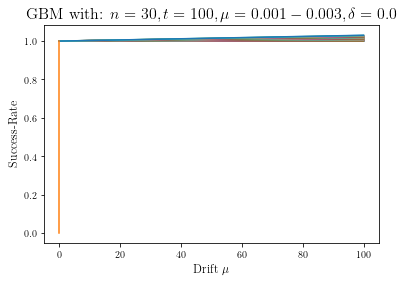

In [46]:
# test: mu
success_rates = []
mus = np.linspace(0.0, 0.0003, 31)
print(mus)

gbm_per_try = 1
r0 = 1.0
delta = 0.0
    
for i in range(len(mus)):
    # test with current config
    cy_i = Currency(1000, 1, mus[i])
    cy_j = Currency(1000, 1, -1*mus[i])
    t_mu = TestRange(gbm_per_try, cy_i, cy_j, r0, mus[i], delta)
    result = t_mu.test_mu()
    success_rates.append(result)

print("Mus:")
print(mus)
print("Success-Rates:")
print(success_rates)

plt.plot(mus, success_rates)

plt.xlabel(r'Drift $\mu$', fontsize=12)
plt.ylabel(r'Success-Rate', fontsize=12)
plt.title(r'GBM with: $n = 30, t = 100, \mu = 0.001-0.003, \delta = 0.0$',fontsize=16)
    
plt.show()

#### Variance $\delta$

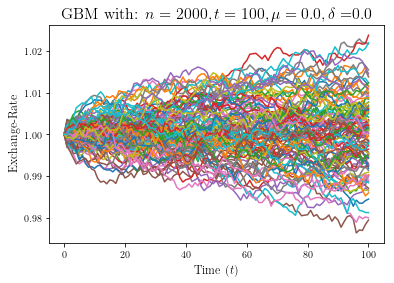

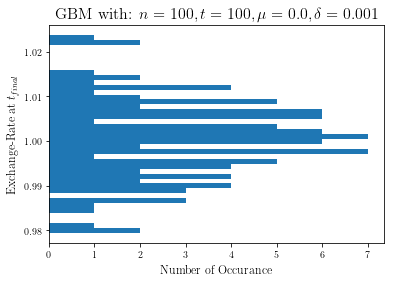

Deltas:
[0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009 0.01  0.011 0.012
 0.013 0.014 0.015 0.016 0.017 0.018 0.019 0.02 ]
Success-Rates:
[0.98]


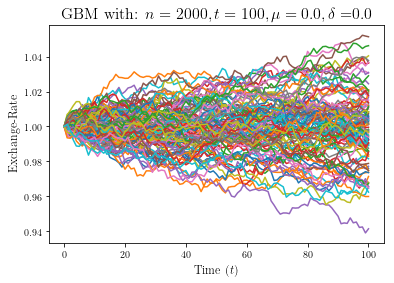

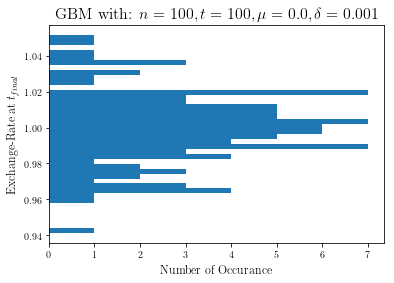

Deltas:
[0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009 0.01  0.011 0.012
 0.013 0.014 0.015 0.016 0.017 0.018 0.019 0.02 ]
Success-Rates:
[0.98, 0.63]


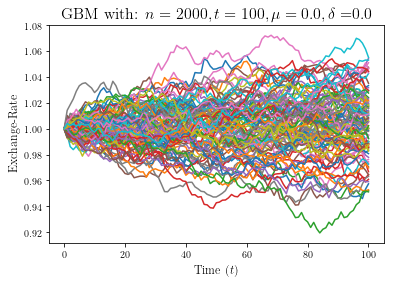

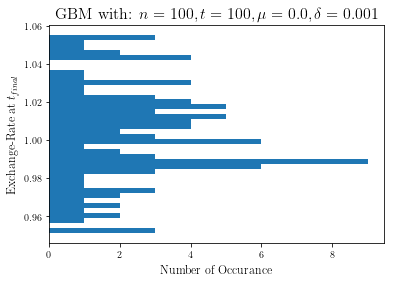

Deltas:
[0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009 0.01  0.011 0.012
 0.013 0.014 0.015 0.016 0.017 0.018 0.019 0.02 ]
Success-Rates:
[0.98, 0.63, 0.43]


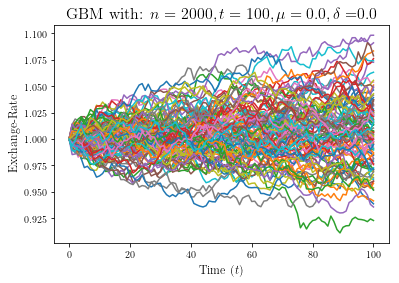

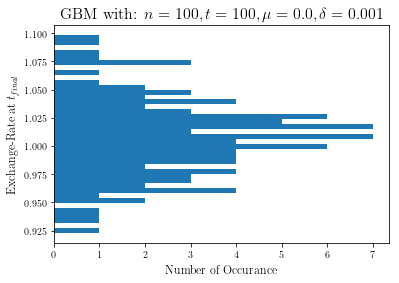

Deltas:
[0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009 0.01  0.011 0.012
 0.013 0.014 0.015 0.016 0.017 0.018 0.019 0.02 ]
Success-Rates:
[0.98, 0.63, 0.43, 0.35]


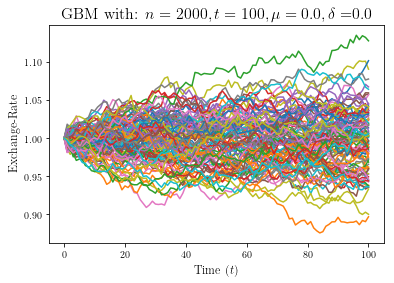

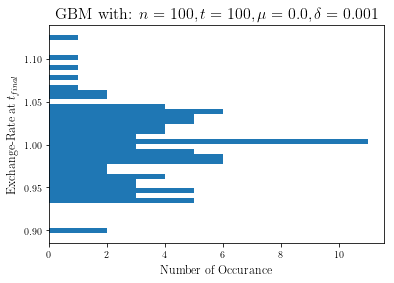

Deltas:
[0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009 0.01  0.011 0.012
 0.013 0.014 0.015 0.016 0.017 0.018 0.019 0.02 ]
Success-Rates:
[0.98, 0.63, 0.43, 0.35, 0.22]


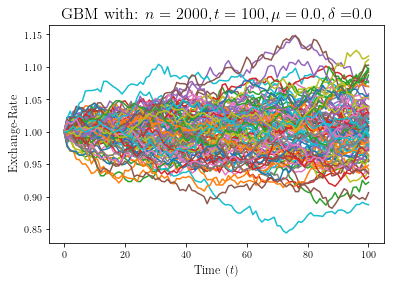

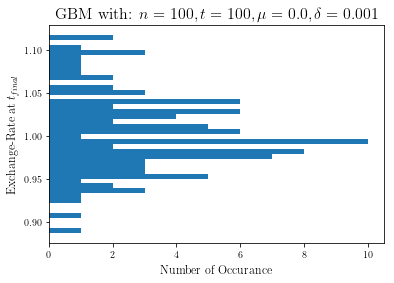

Deltas:
[0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009 0.01  0.011 0.012
 0.013 0.014 0.015 0.016 0.017 0.018 0.019 0.02 ]
Success-Rates:
[0.98, 0.63, 0.43, 0.35, 0.22, 0.18]


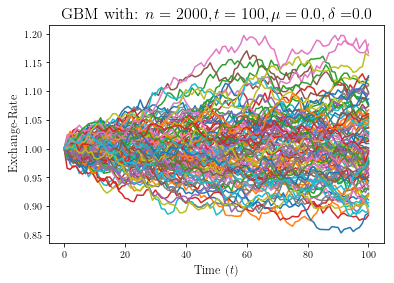

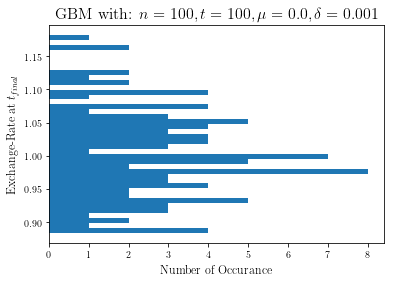

Deltas:
[0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009 0.01  0.011 0.012
 0.013 0.014 0.015 0.016 0.017 0.018 0.019 0.02 ]
Success-Rates:
[0.98, 0.63, 0.43, 0.35, 0.22, 0.18, 0.09]


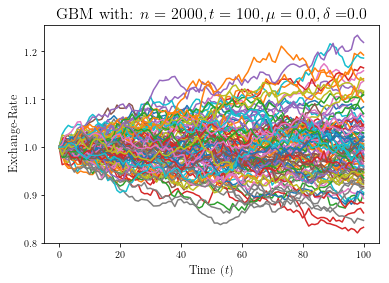

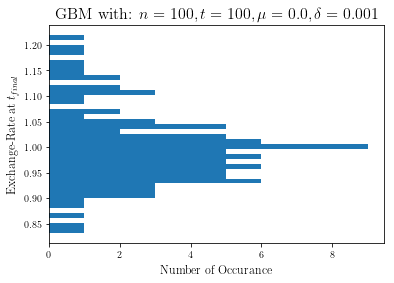

Deltas:
[0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009 0.01  0.011 0.012
 0.013 0.014 0.015 0.016 0.017 0.018 0.019 0.02 ]
Success-Rates:
[0.98, 0.63, 0.43, 0.35, 0.22, 0.18, 0.09, 0.06]


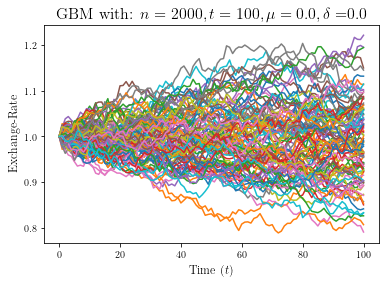

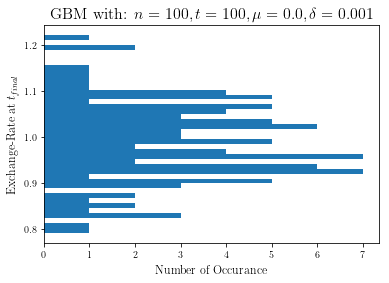

Deltas:
[0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009 0.01  0.011 0.012
 0.013 0.014 0.015 0.016 0.017 0.018 0.019 0.02 ]
Success-Rates:
[0.98, 0.63, 0.43, 0.35, 0.22, 0.18, 0.09, 0.06, 0.02]


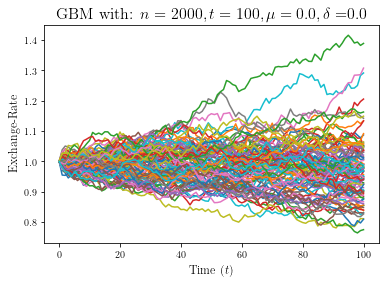

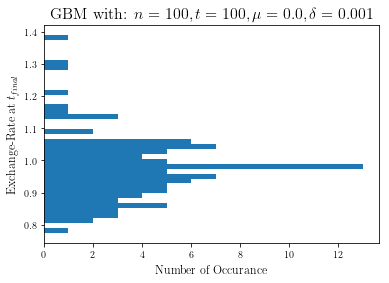

Deltas:
[0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009 0.01  0.011 0.012
 0.013 0.014 0.015 0.016 0.017 0.018 0.019 0.02 ]
Success-Rates:
[0.98, 0.63, 0.43, 0.35, 0.22, 0.18, 0.09, 0.06, 0.02, 0.07]


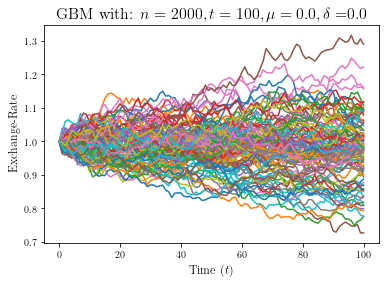

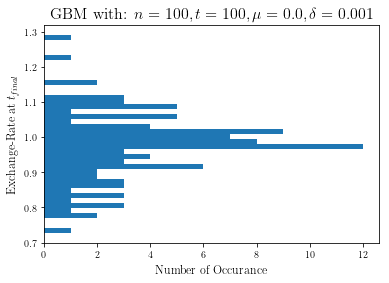

Deltas:
[0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009 0.01  0.011 0.012
 0.013 0.014 0.015 0.016 0.017 0.018 0.019 0.02 ]
Success-Rates:
[0.98, 0.63, 0.43, 0.35, 0.22, 0.18, 0.09, 0.06, 0.02, 0.07, 0.06]


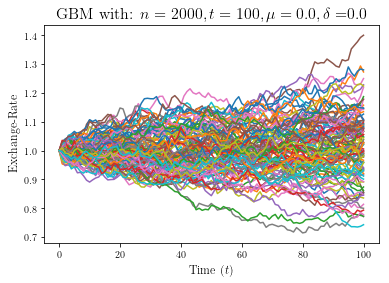

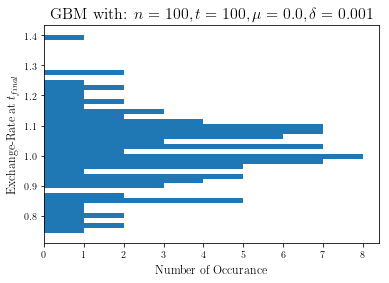

Deltas:
[0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009 0.01  0.011 0.012
 0.013 0.014 0.015 0.016 0.017 0.018 0.019 0.02 ]
Success-Rates:
[0.98, 0.63, 0.43, 0.35, 0.22, 0.18, 0.09, 0.06, 0.02, 0.07, 0.06, 0.03]


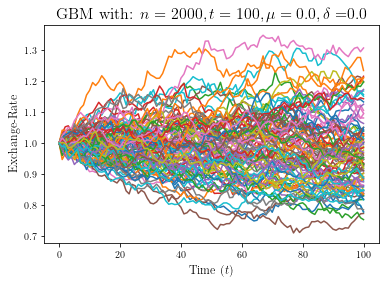

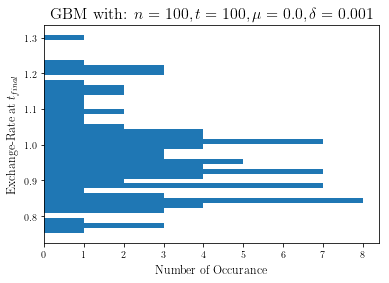

Deltas:
[0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009 0.01  0.011 0.012
 0.013 0.014 0.015 0.016 0.017 0.018 0.019 0.02 ]
Success-Rates:
[0.98, 0.63, 0.43, 0.35, 0.22, 0.18, 0.09, 0.06, 0.02, 0.07, 0.06, 0.03, 0.02]


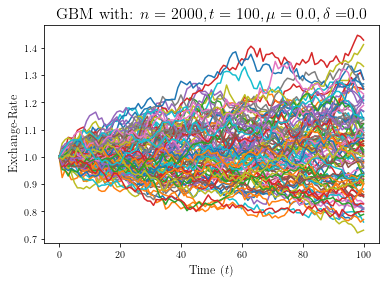

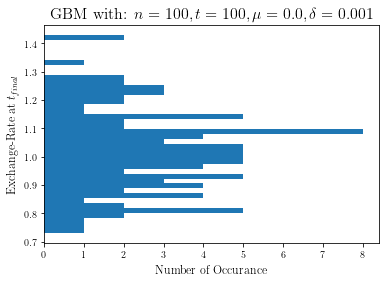

Deltas:
[0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009 0.01  0.011 0.012
 0.013 0.014 0.015 0.016 0.017 0.018 0.019 0.02 ]
Success-Rates:
[0.98, 0.63, 0.43, 0.35, 0.22, 0.18, 0.09, 0.06, 0.02, 0.07, 0.06, 0.03, 0.02, 0.03]


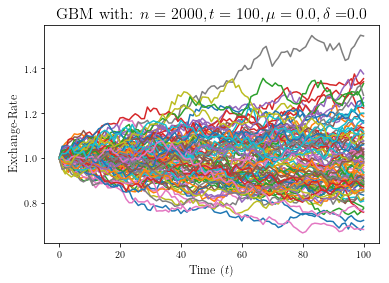

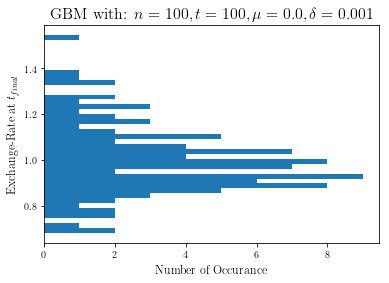

Deltas:
[0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009 0.01  0.011 0.012
 0.013 0.014 0.015 0.016 0.017 0.018 0.019 0.02 ]
Success-Rates:
[0.98, 0.63, 0.43, 0.35, 0.22, 0.18, 0.09, 0.06, 0.02, 0.07, 0.06, 0.03, 0.02, 0.03, 0.0]


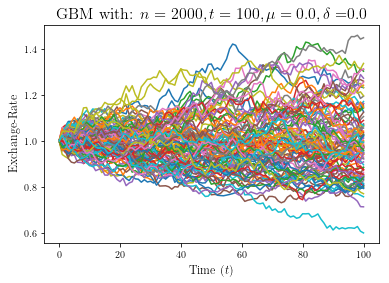

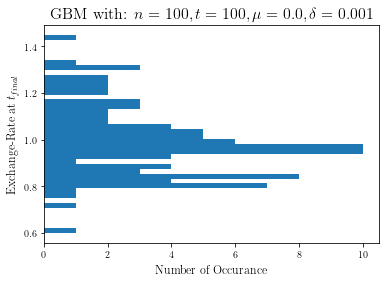

Deltas:
[0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009 0.01  0.011 0.012
 0.013 0.014 0.015 0.016 0.017 0.018 0.019 0.02 ]
Success-Rates:
[0.98, 0.63, 0.43, 0.35, 0.22, 0.18, 0.09, 0.06, 0.02, 0.07, 0.06, 0.03, 0.02, 0.03, 0.0, 0.0]


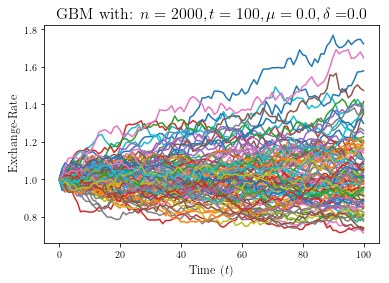

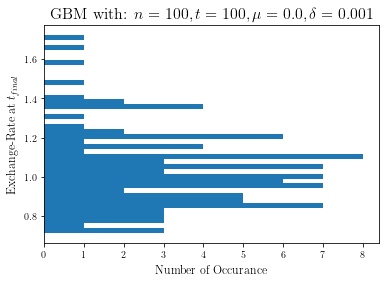

Deltas:
[0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009 0.01  0.011 0.012
 0.013 0.014 0.015 0.016 0.017 0.018 0.019 0.02 ]
Success-Rates:
[0.98, 0.63, 0.43, 0.35, 0.22, 0.18, 0.09, 0.06, 0.02, 0.07, 0.06, 0.03, 0.02, 0.03, 0.0, 0.0, 0.01]


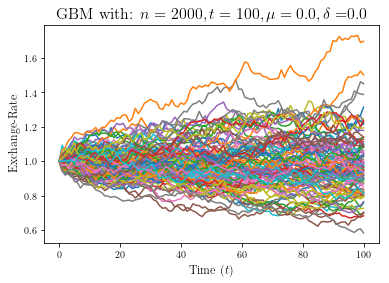

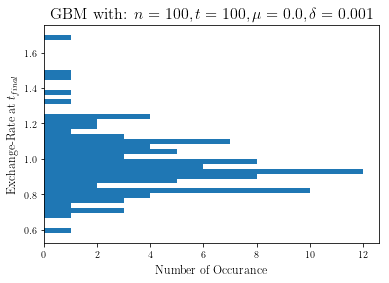

Deltas:
[0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009 0.01  0.011 0.012
 0.013 0.014 0.015 0.016 0.017 0.018 0.019 0.02 ]
Success-Rates:
[0.98, 0.63, 0.43, 0.35, 0.22, 0.18, 0.09, 0.06, 0.02, 0.07, 0.06, 0.03, 0.02, 0.03, 0.0, 0.0, 0.01, 0.01]


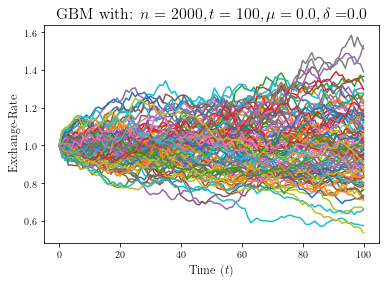

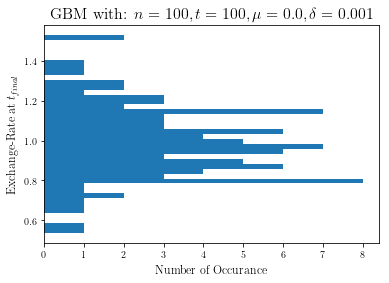

Deltas:
[0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009 0.01  0.011 0.012
 0.013 0.014 0.015 0.016 0.017 0.018 0.019 0.02 ]
Success-Rates:
[0.98, 0.63, 0.43, 0.35, 0.22, 0.18, 0.09, 0.06, 0.02, 0.07, 0.06, 0.03, 0.02, 0.03, 0.0, 0.0, 0.01, 0.01, 0.02]


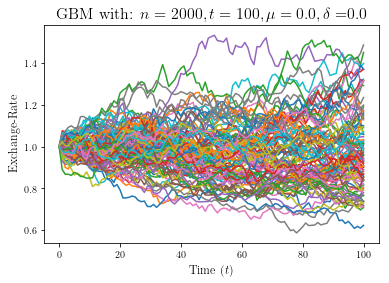

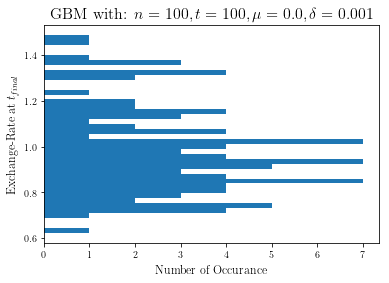

Deltas:
[0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009 0.01  0.011 0.012
 0.013 0.014 0.015 0.016 0.017 0.018 0.019 0.02 ]
Success-Rates:
[0.98, 0.63, 0.43, 0.35, 0.22, 0.18, 0.09, 0.06, 0.02, 0.07, 0.06, 0.03, 0.02, 0.03, 0.0, 0.0, 0.01, 0.01, 0.02, 0.01]


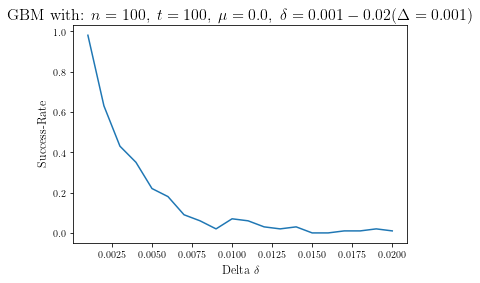

In [40]:
# test: delta
success_rates = []
deltas = np.linspace(0.001, 0.02, 20)

gbm_per_try = 100
r0 = 1.0
mu = 0.0
cy_i = Currency(1000, 1, 0.0)
cy_j = Currency(1000, 1, 0.0)
    
for i in range(len(deltas)):
    # test with current config
    t_delta = TestRange(gbm_per_try, cy_i, cy_j, r0, mu, deltas[i])
    t_delta.test_delta()
    
    # calc success rate
    success_rate = t_delta.succeded / (t_delta.succeded + t_delta.failed)
    success_rates.append(success_rate)
    
    print("Deltas:")
    print(deltas)
    print("Success-Rates:")
    print(success_rates)

plt.plot(deltas, success_rates)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.xlabel(r'Delta $\delta$', fontsize=12)
plt.ylabel(r'Success-Rate', fontsize=12)
plt.title(r'GBM with: $n = 100, \;t = 100, \;\mu = 0.0, \;\delta = 0.001-0.02 (\Delta = 0.001)$',fontsize=16)

plt.show()